# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../Updated_V2/nf_output/countData/countData.tsv'
metaPath = '../Guegler_T7_SraRunTable.csv' # metadata from SRA
gffPath = '../Updated_V2/nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
df_initial = df_initial.drop(columns=['SRR13084829_sorted.bam', 'SRR13084830_sorted.bam', 'SRR13084831_sorted.bam', 
                                      'SRR13084832_sorted.bam', 'SRR13084833_sorted.bam', 'SRR13084834_sorted.bam', 
                                      'SRR13084835_sorted.bam', 'SRR13084836_sorted.bam', 'SRR13084837_sorted.bam', 
                                      'SRR13084838_sorted.bam', 'SRR13084839_sorted.bam', 'SRR13084840_sorted.bam'])
metadata = pd.read_csv(metaPath)
metadata = metadata[metadata['plasmid'] == 'pBR322-toxIN']

In [4]:
df_initial.head()

,Chr,Start,End,Strand,Length,SRR13084823_sorted.bam,SRR13084828_sorted.bam,SRR13084824_sorted.bam,SRR13084817_sorted.bam,SRR13084827_sorted.bam,SRR13084821_sorted.bam,SRR13084822_sorted.bam,SRR13084820_sorted.bam,SRR13084818_sorted.bam,SRR13084825_sorted.bam,SRR13084819_sorted.bam,SRR13084826_sorted.bam
Geneid,,,,,,,,,,,,,,,,,
gene-b0001,U00096.3,190,255,+,66,9522,2461,2605,7394,1359,1598,2124,1694,2620,1745,1368,2773
gene-b0002,U00096.3,337,2799,+,2463,18008,3302,14282,16256,3087,4595,2615,3323,15776,8589,4889,5768
gene-b0003,U00096.3,2801,3733,+,933,10024,1767,8294,9731,1566,2367,1616,2002,9381,5478,3359,3443
gene-b0004,U00096.3,3734,5020,+,1287,12019,2300,10302,11487,1766,2696,1925,2477,11648,7788,4481,4639
gene-b0005,U00096.3,5234,5530,+,297,364,55,342,298,67,113,65,149,508,353,211,250


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,ercc_standard,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,phage,plasmid,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,substrain,time_post-infection
0,SRR13084817,RNA-Seq,69,2206520088,PRJNA679480,SAMN16834528,815280924,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531489,GSM4914573,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914573,Bacterial liquid culture,SRP293243,K-12,MG1655,0.0
1,SRR13084818,RNA-Seq,69,2213756118,PRJNA679480,SAMN16834491,818011356,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531490,GSM4914574,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914574,Bacterial liquid culture,SRP293243,K-12,MG1655,2.5
2,SRR13084819,RNA-Seq,69,1581480138,PRJNA679480,SAMN16834485,584321274,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531491,GSM4914575,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:27:00Z,1,GSM4914575,Bacterial liquid culture,SRP293243,K-12,MG1655,5.0
3,SRR13084820,RNA-Seq,69,1460984334,PRJNA679480,SAMN16834484,561309085,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531492,GSM4914576,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:27:00Z,1,GSM4914576,Bacterial liquid culture,SRP293243,K-12,MG1655,10.0
4,SRR13084821,RNA-Seq,69,2222009898,PRJNA679480,SAMN16834483,812687637,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531493,GSM4914577,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914577,Bacterial liquid culture,SRP293243,K-12,MG1655,20.0
5,SRR13084822,RNA-Seq,69,1457150349,PRJNA679480,SAMN16834482,534875059,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531494,GSM4914578,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:27:00Z,1,GSM4914578,Bacterial liquid culture,SRP293243,K-12,MG1655,30.0
6,SRR13084823,RNA-Seq,69,2652171630,PRJNA679480,SAMN16834481,975891801,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531495,GSM4914579,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914579,Bacterial liquid culture,SRP293243,K-12,MG1655,0.0
7,SRR13084824,RNA-Seq,69,1849919118,PRJNA679480,SAMN16834480,685371325,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531496,GSM4914580,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:28:00Z,1,GSM4914580,Bacterial liquid culture,SRP293243,K-12,MG1655,2.5
8,SRR13084825,RNA-Seq,69,1796950992,PRJNA679480,SAMN16834479,663468831,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531497,GSM4914581,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:28:00Z,1,GSM4914581,Bacterial liqu

## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM4914573': '0_R1', 'GSM4914574': '2.5_R1', 'GSM4914575': '5_R1',
              'GSM4914576': '10_R1', 'GSM4914577': '20_R1', 'GSM4914578': '30_R1',
              'GSM4914579': '0_R2', 'GSM4914580': '2.5_R2', 'GSM4914581': '5_R2',
              'GSM4914582': '10_R2', 'GSM4914583': '20_R2', 'GSM4914584': '30_R2',
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,ercc_standard,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,phage,plasmid,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,substrain,time_post-infection
0,SRR13084817,RNA-Seq,69,2206520088,PRJNA679480,SAMN16834528,815280924,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531489,GSM4914573,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914573,Bacterial liquid culture,SRP293243,K-12,MG1655,0.0


In [9]:
metadataFull.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,ercc_standard,Experiment,GEO_Accession (exp),Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,phage,plasmid,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,strain,substrain,time_post-infection,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR13084817_sorted.bam,SRR13084817,RNA-Seq,69,2206520088,PRJNA679480,SAMN16834528,815280924,GEO,public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",Prior to extraction,SRX9531489,GSM4914573,NextSeq 500,PAIRED,cDNA,TRANSCRIPTOMIC,Escherichia coli str. K-12 substr. MG1655,T7,pBR322-toxIN,ILLUMINA,2021-06-01T00:00:00Z,2020-11-19T10:29:00Z,1,GSM4914573,Bacterial liquid culture,SRP293243,K-12,MG1655,0.0,SRR13084817_sorted.bam,0_R1


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['0_R1', '0_R2', '2.5_R1', '2.5_R2', '5_R1', '5_R2', '10_R1', '10_R2', '20_R1', '20_R2', '30_R1', '30_R2']]
df

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2
Geneid,,,,,,,,,,,,
gene-b0001,7394,9522,2620,2605,1368,1745,1694,2773,1598,1359,2124,2461
gene-b0002,16256,18008,15776,14282,4889,8589,3323,5768,4595,3087,2615,3302
gene-b0003,9731,10024,9381,8294,3359,5478,2002,3443,2367,1566,1616,1767
gene-b0004,11487,12019,11648,10302,4481,7788,2477,4639,2696,1766,1925,2300
gene-b0005,298,364,508,342,211,353,149,250,113,67,65,55
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-T7p56,9,3,34,10,4,40,4071,8751,81531,53563,70518,77214
gene-T7p57,44,45,295,69,52,439,19885,38288,658200,447211,800052,928809
gene-T7p58,9,13,58,13,7,79,4075,7497,126265,86757,137529,167099


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/NC_001604.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "NC_001604.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
4506,NC_001604.1,RefSeq,gene,891.0,1468.0,.,+,.,gene-T7p01,T7p01,Gene,protein_coding,T7p01,gene-T7p01,ocr-like anti-restriction,ocr-like anti-restriction,2568.0,"moron, auxiliary metabolic gene and host takeover"
4507,NC_001604.1,RefSeq,gene,1278.0,1433.0,.,+,.,gene-T7p02,T7p02,Gene,protein_coding,T7p02,gene-T7p02,hypothetical protein,hypothetical protein,7202.0,unknown function
4508,NC_001604.1,RefSeq,gene,1469.0,3138.0,.,+,.,gene-T7p03,T7p03,Gene,protein_coding,T7p03,gene-T7p03,serine-threonine kinase,serine-threonine kinase,2828.0,other
4509,NC_001604.1,RefSeq,gene,1496.0,1639.0,.,+,.,gene-T7p04,T7p04,Gene,protein_coding,T7p04,gene-T7p04,hypothetical protein,hypothetical protein,16572.0,unknown function
4510,NC_001604.1,RefSeq,gene,1636.0,1972.0,.,+,.,gene-T7p05,T7p05,Gene,protein_coding,T7p05,gene-T7p05,hypothetical protein,hypothetical protein,8393.0,unknown function
4511,NC_001604.1,RefSeq,gene,1636.0,1797.0,.,+,.,gene-T7p06,T7p06,Gene,protein_coding,T7p06,gene-T7p06,hypothetical protein,hypothetical protein,8393.0,unknown function
4512,NC_001604.1,RefSeq,gene,3139.0,5887.0,.,+,.,gene-T7p07,T7p07,Gene,protein_coding,T7p07,gene-T7p07,RNA polymerase,RNA polymerase,414.0,"DNA, RNA and nucleotide metabolism"
4513,NC_001604.1,RefSeq,gene,5888.0,6448.0,.,+,.,gene-T7p08,T7p08,Gene,protein_coding,T7p08,gene-T7p08,dGTPase inhibitor%3B target for F exclusion,dGTPase inhibitor target for F exclusion,2949.0,other
4514,NC_001604.1,RefSeq,gene,6007.0,6135.0,.,+,.,gene-T7p09,T7p09,Gene,protein_coding,T7p09,gene-T7p09,hypothetical protein,hypothetical protein,2490.0,unknown function
4515,NC_001604.1,RefSeq,gene,6449.0,7588.0,.,+,.,gene-T7p10,T7p10,Gene,protein_coding,T7p10,gene-T7p10,DNA ligase,DNA ligase,30362.0,"DNA, RNA and nucleotide metabolism"


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'U00096.3', 'host', 'phage')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

Perform in silico rRNA depletion.

In [14]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2
Geneid,,,,,,,,,,,,
gene-b0435,6417,7340,3626,3329,1361,1569,918,1488,1277,806,1689,1904
gene-b1336,87,139,93,56,40,44,25,60,34,14,21,48
gene-b1145,772,1168,636,381,368,370,297,523,267,201,195,215
gene-b3597,201,266,162,142,43,70,51,63,48,30,40,93
gene-b2545,320,386,339,239,141,209,125,188,129,69,74,106
...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b4663,3581,4673,3812,2886,2584,2667,2370,2782,1407,1060,796,965
gene-b3552,1180,1270,1285,1052,831,1057,818,1341,580,389,208,215
gene-b3143,40,50,42,20,12,16,14,13,22,6,5,17


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [15]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [16]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b0435,268.637618,249.378669,125.866214,145.154210,78.663245,74.300216,45.469267,55.521234,53.307462,49.359334,124.938060,130.325032,host,bolA
gene-b1336,0.762776,0.986952,0.675805,0.512964,0.487301,0.438709,0.262886,0.469952,0.299802,0.184808,0.331103,0.691157,host,abgT
gene-b1145,15.234310,18.701900,10.407424,7.835532,10.030326,8.263049,6.938237,9.199205,5.258650,5.809829,6.810934,6.947323,host,ymfK
gene-b3597,2.359080,2.532197,1.577399,1.737529,0.702927,0.933436,0.713038,0.662446,0.566025,0.522073,0.837642,1.789473,host,yibH
gene-b2545,4.017275,3.931749,3.528287,3.126502,2.448010,2.969719,1.860309,2.105350,1.618078,1.273657,1.649664,2.182223,host,yphC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b4663,547.991438,580.341696,483.658925,459.970571,545.806393,461.573694,428.930195,379.361550,214.675939,237.237567,215.293149,241.494369,host,azuC
gene-b3552,23.809492,20.796561,21.496945,22.108328,23.147263,24.120834,19.522735,24.109274,11.671119,11.485650,7.428922,7.105217,host,yiaD
gene-b3143,0.774594,0.783868,0.673951,0.408340,0.329976,0.356887,0.327963,0.230071,0.428971,0.181759,0.185831,0.547145,host,yraI


In [17]:
# Check gene names unique
len(tpms['Symbol'].unique())

4544

Log2+1 normalization tpms

In [18]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b0435,8.074878,7.967968,6.987164,7.191348,6.315842,6.234582,5.538205,5.820721,5.763079,5.654187,6.976571,7.036998,host,bolA
gene-b1336,0.817849,0.990557,0.744854,0.597378,0.572697,0.524775,0.336724,0.555769,0.378292,0.244653,0.412622,0.758011,host,abgT
gene-b1145,4.020974,4.300263,3.511901,3.143317,3.463404,3.211487,2.988819,3.350385,2.645851,2.767618,2.965495,2.990469,host,ymfK
gene-b3597,1.748066,1.820566,1.365916,1.452874,0.768016,0.951167,0.776557,0.733308,0.647107,0.606038,0.877855,1.479993,host,yibH
gene-b2545,2.326904,2.302099,2.178965,2.044919,1.785764,1.989037,1.516171,1.634756,1.388508,1.185014,1.405809,1.670035,host,yphC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b4663,9.100640,9.183243,8.920826,8.848531,9.094886,8.853539,8.747959,8.571228,7.752721,7.896257,7.756844,7.921807,host,azuC
gene-b3552,4.632820,4.446029,4.491657,4.530341,4.593788,4.650812,4.359151,4.650148,3.663472,3.642199,3.075348,3.018851,host,yiaD
gene-b3143,0.827489,0.835009,0.743257,0.493996,0.411400,0.440300,0.409215,0.298742,0.514976,0.240936,0.245898,0.629609,host,yraI


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [19]:
columnOrder = ['0_R1', '0_R2', '2.5_R1', '2.5_R2', '5_R1', '5_R2', '10_R1', '10_R2', '20_R1', '20_R2', '30_R1', '30_R2']

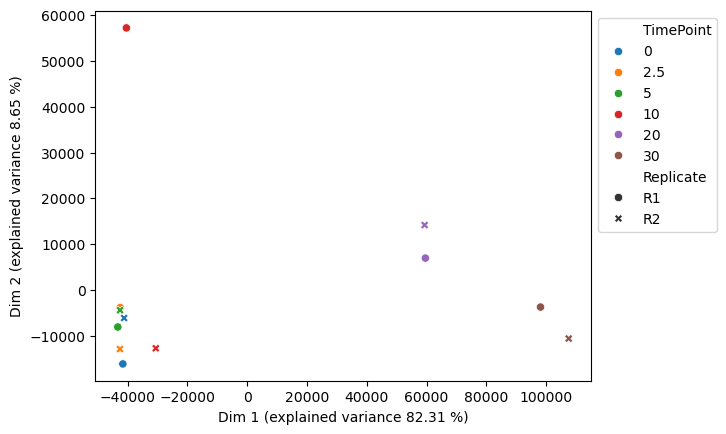

In [20]:
txPCA(tpms[columnOrder])

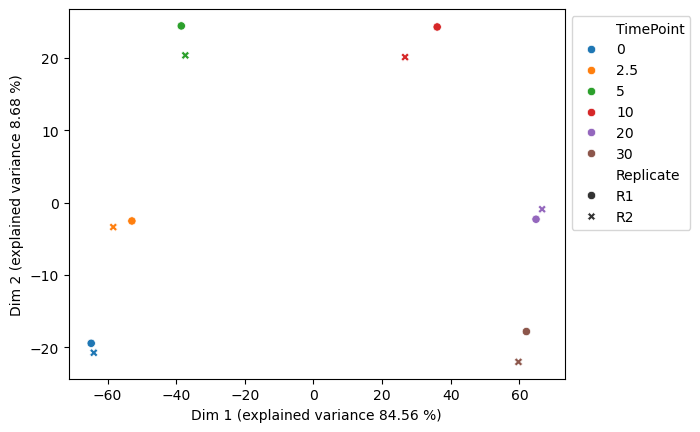

In [21]:
txPCA(logTPMs[columnOrder])

In [22]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

In [23]:
logTPMs

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol
Geneid,,,,,,,,,,,,,,
gene-b0435,8.074878,7.967968,6.987164,7.191348,6.315842,6.234582,5.538205,5.820721,5.763079,5.654187,6.976571,7.036998,host,bolA
gene-b1336,0.817849,0.990557,0.744854,0.597378,0.572697,0.524775,0.336724,0.555769,0.378292,0.244653,0.412622,0.758011,host,abgT
gene-b1145,4.020974,4.300263,3.511901,3.143317,3.463404,3.211487,2.988819,3.350385,2.645851,2.767618,2.965495,2.990469,host,ymfK
gene-b3597,1.748066,1.820566,1.365916,1.452874,0.768016,0.951167,0.776557,0.733308,0.647107,0.606038,0.877855,1.479993,host,yibH
gene-b2545,2.326904,2.302099,2.178965,2.044919,1.785764,1.989037,1.516171,1.634756,1.388508,1.185014,1.405809,1.670035,host,yphC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b4663,9.100640,9.183243,8.920826,8.848531,9.094886,8.853539,8.747959,8.571228,7.752721,7.896257,7.756844,7.921807,host,azuC
gene-b3552,4.632820,4.446029,4.491657,4.530341,4.593788,4.650812,4.359151,4.650148,3.663472,3.642199,3.075348,3.018851,host,yiaD
gene-b3143,0.827489,0.835009,0.743257,0.493996,0.411400,0.440300,0.409215,0.298742,0.514976,0.240936,0.245898,0.629609,host,yraI


tpmHost

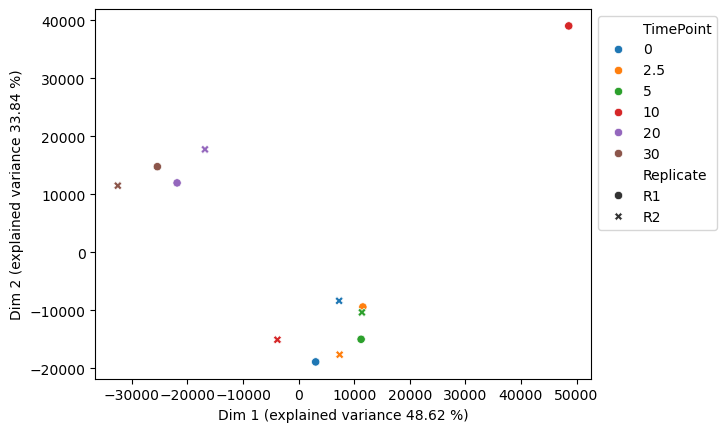

In [24]:
txPCA(tpmHost[columnOrder])

tpmPhage

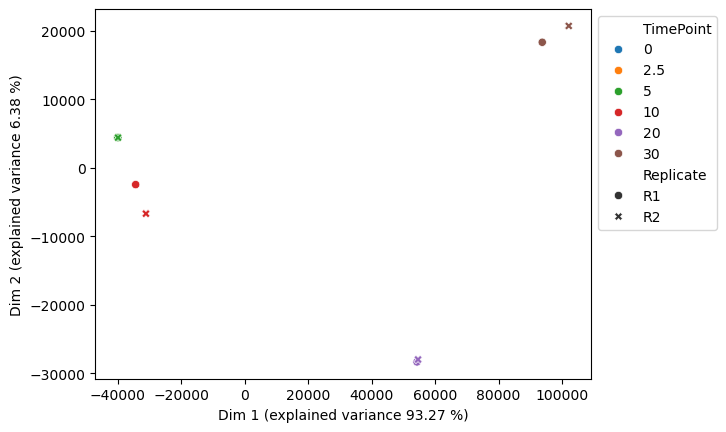

In [25]:
txPCA(tpmPhage[columnOrder])

logTPM Host

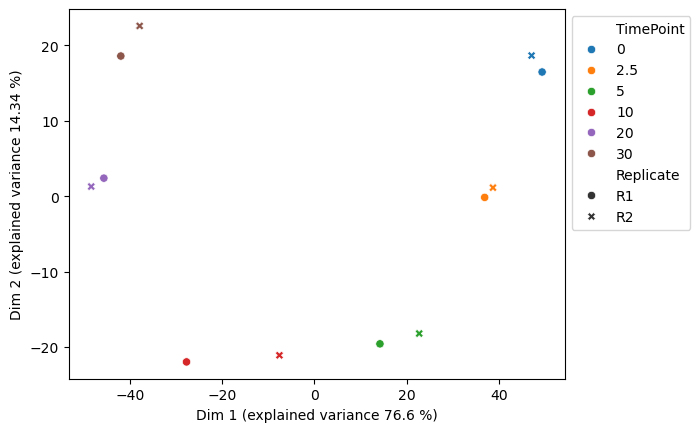

In [26]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

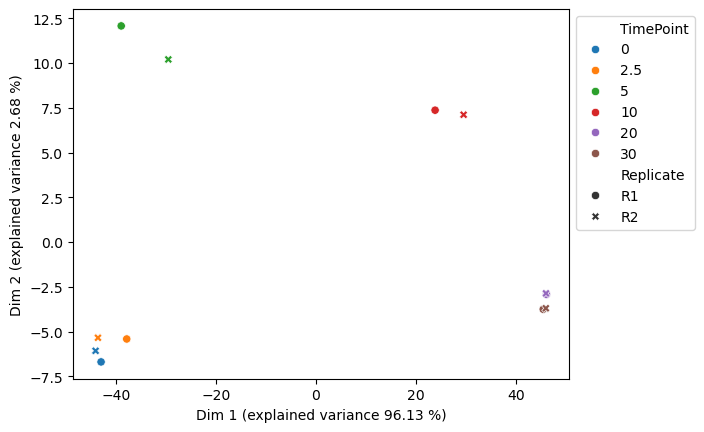

In [27]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Replicates seem to be fine, raw tpms T10 far away, but logTPMs look very good. Keep all!

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [28]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['0', '2.5', '5', '10', '20', '30']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b0435,259.008144,135.510212,76.481730,50.495250,51.333398,127.631546,host,bolA
gene-b1336,0.874864,0.594384,0.463005,0.366419,0.242305,0.511130,host,abgT
gene-b1145,16.968105,9.121478,9.146687,8.068721,5.534239,6.879128,host,ymfK
gene-b3597,2.445639,1.657464,0.818181,0.687742,0.544049,1.313557,host,yibH
gene-b2545,3.974512,3.327394,2.708865,1.982829,1.445867,1.915943,host,yphC
...,...,...,...,...,...,...,...,...
gene-b4663,564.166567,471.814748,503.690043,404.145872,225.956753,228.393759,host,azuC
gene-b3552,22.303026,21.802637,23.634048,21.816005,11.578385,7.267069,host,yiaD
gene-b3143,0.779231,0.541146,0.343431,0.279017,0.305365,0.366488,host,yraI


In [29]:
TPMsds = TPMsds[['0', '2.5', '5', '10', '20', '30']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b0435,9.629474,9.643998,2.181515,5.025983,1.974064,2.693486,host,bolA
gene-b1336,0.112088,0.081420,0.024296,0.103533,0.057497,0.180027,host,abgT
gene-b1145,1.733795,1.285946,0.883639,1.130484,0.275589,0.068194,host,ymfK
gene-b3597,0.086559,0.080065,0.115255,0.025296,0.021976,0.475916,host,yibH
gene-b2545,0.042763,0.200892,0.260854,0.122520,0.172211,0.266279,host,yphC
...,...,...,...,...,...,...,...,...
gene-b4663,16.175129,11.844177,42.116350,24.784323,11.280814,13.100610,host,azuC
gene-b3552,1.506466,0.305692,0.486785,2.293269,0.092735,0.161853,host,yiaD
gene-b3143,0.004637,0.132805,0.013456,0.048946,0.123606,0.180657,host,yraI


In [30]:
propExp = proportionalExp(TPMmeans[['0', '2.5', '5', '10', '20', '30']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,0,2.5,5,10,20,30,Entity,Symbol
Geneid,,,,,,,,
gene-b0435,1.000000,0.523189,0.295287,0.194956,0.198192,0.492770,host,bolA
gene-b1336,1.000000,0.679402,0.529231,0.418830,0.276963,0.584239,host,abgT
gene-b1145,1.000000,0.537566,0.539052,0.475523,0.326155,0.405415,host,ymfK
gene-b3597,1.000000,0.677722,0.334547,0.281212,0.222457,0.537102,host,yibH
gene-b2545,1.000000,0.837183,0.681559,0.498886,0.363785,0.482057,host,yphC
...,...,...,...,...,...,...,...,...
gene-b4663,1.000000,0.836304,0.892804,0.716359,0.400514,0.404834,host,azuC
gene-b3552,0.943682,0.922510,1.000000,0.923075,0.489903,0.307483,host,yiaD
gene-b3143,1.000000,0.694461,0.440731,0.358067,0.391880,0.470320,host,yraI


## 5. Phage gene classification

In [31]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [32]:
# Export fractional expressions with T=0.6 + Host/Phage Annotation for Orthofinder Analysis
# t = classLabelThreshold(propExp)
# t = t[t["Entity"] == "phage"]
# t["Host"] = "Escherichia_Coli_plusToxIN"
# t["Phage"] = "Enterobacteria_phage_T7"
# t.to_csv("/ceph/ibmi/studenten/waffen/Cross_Analysis/Orthofinder_Clustering/Fractional_Expressions/T060/Guegler_T7_plusToxIN_fractional_expression_T=0.6.tsv", sep="\t")

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('early')
        elif timePoint == 2:
            labels.append('early')
        elif timePoint == 3:
            labels.append('middle')
        elif timePoint == 4:
            labels.append('late')
        elif timePoint == 5:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [34]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [35]:
TPMmeans

,0,2.5,5,10,20,30,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,,,,
gene-b0435,259.008144,135.510212,76.481730,50.495250,51.333398,127.631546,host,bolA,None,None
gene-b1336,0.874864,0.594384,0.463005,0.366419,0.242305,0.511130,host,abgT,None,None
gene-b1145,16.968105,9.121478,9.146687,8.068721,5.534239,6.879128,host,ymfK,None,None
gene-b3597,2.445639,1.657464,0.818181,0.687742,0.544049,1.313557,host,yibH,None,None
gene-b2545,3.974512,3.327394,2.708865,1.982829,1.445867,1.915943,host,yphC,None,None
...,...,...,...,...,...,...,...,...,...,...
gene-b4663,564.166567,471.814748,503.690043,404.145872,225.956753,228.393759,host,azuC,None,None
gene-b3552,22.303026,21.802637,23.634048,21.816005,11.578385,7.267069,host,yiaD,None,None
gene-b3143,0.779231,0.541146,0.343431,0.279017,0.305365,0.366488,host,yraI,None,None


In [36]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassThreshold'].value_counts()

ClassThreshold
late      33
middle    27
Name: count, dtype: int64

Add classes to other dfs.

In [37]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[gff3_final['seq_id'] == 'U00096.3']
gff3_phage = gff3_final[gff3_final['seq_id'] == 'NC_001604.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [38]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [39]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,0_R1,0_R2,2.5_R1,2.5_R2,5_R1,5_R2,10_R1,10_R2,20_R1,20_R2,30_R1,30_R2,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,,,,
gene-b0435,268.637618,249.378669,125.866214,145.154210,78.663245,74.300216,45.469267,55.521234,53.307462,49.359334,124.938060,130.325032,host,bolA,None,None,44.578109
gene-b1336,0.762776,0.986952,0.675805,0.512964,0.487301,0.438709,0.262886,0.469952,0.299802,0.184808,0.331103,0.691157,host,abgT,None,None,0.098601
gene-b1145,15.234310,18.701900,10.407424,7.835532,10.030326,8.263049,6.938237,9.199205,5.258650,5.809829,6.810934,6.947323,host,ymfK,None,None,1.565208
gene-b3597,2.359080,2.532197,1.577399,1.737529,0.702927,0.933436,0.713038,0.662446,0.566025,0.522073,0.837642,1.789473,host,yibH,None,None,0.382395
gene-b2545,4.017275,3.931749,3.528287,3.126502,2.448010,2.969719,1.860309,2.105350,1.618078,1.273657,1.649664,2.182223,host,yphC,None,None,0.314347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-b4663,547.991438,580.341696,483.658925,459.970571,545.806393,461.573694,428.930195,379.361550,214.675939,237.237567,215.293149,241.494369,host,azuC,None,None,44.077350
gene-b3552,23.809492,20.796561,21.496945,22.108328,23.147263,24.120834,19.522735,24.109274,11.671119,11.485650,7.428922,7.105217,host,yiaD,None,None,2.247027
gene-b3143,0.774594,0.783868,0.673951,0.408340,0.329976,0.356887,0.327963,0.230071,0.428971,0.181759,0.185831,0.547145,host,yraI,None,None,0.096426


In [40]:
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [41]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]

In [42]:
# Full TPM table
tpms.to_csv('Guegler_T7_plusToxIN_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Guegler_T7_plusToxIN_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Guegler_T7_plusToxIN_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Guegler_T7_plusToxIN_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Guegler_T7_plusToxIN_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Guegler_T7_plusToxIN_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Guegler_T7_plusToxIN_phage_gff3.tsv', sep='\t')